# BHM Noise Simulations
Exploring the affect of noise on recovery.

BHM short for "best host model" is how I identify the model with a single component.


In [1]:
import os
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd
import glob
import sqlalchemy as sa
from bin.coadd_analysis_script import load_sql_table
%matplotlib inline


/home/jneal/Phd/Codes/companion_simulations/bin/__init__.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/jneal/anaconda3/envs/sims/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/jneal/anaconda3/envs/sims/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jneal/anaconda3/envs/sims/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jneal/anaconda3/envs/sims/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jneal/anaconda3/envs/sims/lib/python3.6/site-packages/ipykernel/kern

In [2]:
class SnrDistribution(object):
    def __init__(self, df, snr, teff):
        #ddf.to_numeric(s, errors='coerce')
        self.df = df
        self.snr = snr
        self.teff = teff
        self.size = len(self.df)
        
    
    def mean(self, column, nan=True):
        try:
            if nan:
                return np.nanmean(self.df[column])
            else: 
                return np.mean(self.df[column])
        except KeyError:
            return np.nan

    def std(self, column, nan=True):
        try:
            if nan:
                return np.nanstd(self.df[column])
            else: 
                return np.std(self.df[column])
        except KeyError:
            return np.nan

In [3]:
class SimReader(object):
    def __init__(self, base="/home/jneal/Desktop/Inbox/a/bhm_noise_sim/analysis",
                 namebase="BSBHMNOISE",
                 prefix="", mode="bhm", chi2_val="coadd_chi2"):
        self.base = base
        self.namebase = namebase.upper()
        self.prefix = prefix.upper()
        if mode in ["iam", "tcm", "bhm"]:
            self.mode = mode
        else:
            raise ValueError("Invalid SimReader mode")
        if chi2_val in ["chi2_1", "chi2_2", "chi2_3", "chi2_4", "coadd_chi2"]:
            self.chi2_val = chi2_val
        else:
            raise ValueError("Invalid chi2_val.")
            
    def load_results(self, teff, snr):
        starname = "{}{}{}N{}".format(self.prefix, self.namebase, teff, snr)
        directory = os.path.join(self.base, starname, self.mode)
        df_store = pd.DataFrame()
        # print(directory)
        dbs = glob.glob(os.path.join(directory, "*_coadd_{}_chisqr_results.db".format(self.mode)))
        for dbname in dbs:
            # print(dbname)
            match = re.search("N\d{1,4}-(\d{1,5})_coadd_"+"{}".format(self.mode), dbname, flags=0)
            obsnum = match.group(1)
            try:
                table = load_sql_table(dbname, verbose=False, echo=False)
                dbdf = pd.read_sql(sa.select(table.c).order_by(table.c[self.chi2_val].asc()).limit(1), table.metadata.bind)
                dbdf["snr"] = snr   # Add SNR column
                dbdf["obsnum"] = obsnum # Add Obsnum column
                df_store = dbdf.append(df_store)
            except Exception as e:
                print(e)
                print(f"Didn't get Database for teff={teff}-snr={snr}-obsnum={obsnum}")
        # Coerce to be numeric columns
        c = df_store.columns[df_store.dtypes.eq(object)]
        df_store[c] = df_store[c].apply(pd.to_numeric, errors='coerce', axis=0)
        return SnrDistribution(df_store, snr=snr, teff=teff)


In [4]:
noises = [0, 5, 10, 25, 50, 100, 500, 1000]
bhm_teffs = [4000, 5200] #, 6000]
scale = ["", "SCALAR", "LINEAR"]
chi2_val = "coadd_chi2"


In [5]:
BHMSimReader = SimReader(base="/home/jneal/Desktop/Inbox/a/bhm_noise_sim/analysis",
                         namebase="BSBHMNOISE",
                         prefix="",
                         mode="bhm")

df_bhm_store = [[0]*len(noises) for n in range(len(bhm_teffs))]
# print(df_bhm_store)

for i, teff in enumerate(bhm_teffs):
    print("teff = {}".format(teff))
    for j, noise in enumerate(noises):
        df = BHMSimReader.load_results(teff, noise)   
        df_bhm_store[i][j] = df

print("Done")

teff = 4000
teff = 5200
Done


In [6]:
df_bhm_store[0][3].mean("gamma")

9.0

In [7]:
import matplotlib
import matplotlib.lines as lines
lines_array = list(lines.lineStyles.keys())

def analysis_param(df_store, param, index, individual=False, limits=None):
    if individual:
        plt.figure()
    for i, t in enumerate(df_store):
        # print(i, t, len(t))
        means = [df.mean(param) for df in t ]
        std = [df.std(param) for df in t]
        label = "{}".format(index[i])
        if label == "":
            label = "None"
        plt.errorbar(noises, means, std, marker=".", label=label, ls=lines_array[i])
        
        if individual:
            plt.xlabel("SNR")
            plt.ylabel(param)
            if limits is not None:
                plt.xlim(limits)
            plt.legend()
            plt.title("Distribution of simulated results. {}". format(param))
            plt.show()
    if not individual:
        plt.xlabel("SNR")
        plt.ylabel(param)
        if limits is not None:
            plt.xlim(limits)
        plt.legend()
        plt.title("Distribution of simulated results.")
        plt.show()
    

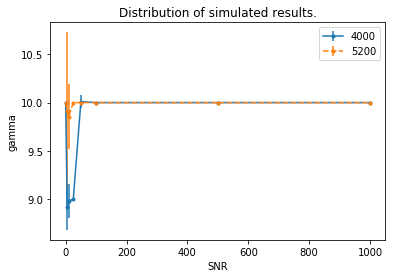

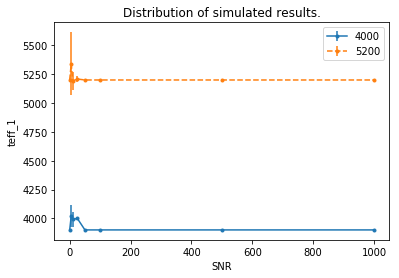

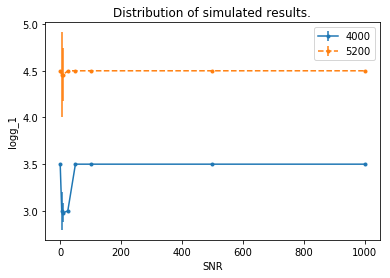

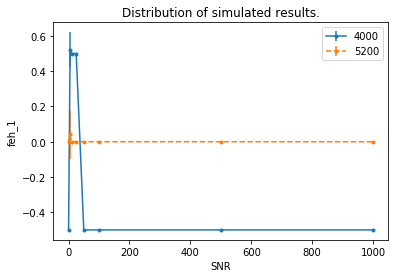

In [8]:
# All temperatures together.
analysis_param(df_bhm_store, "gamma", bhm_teffs, individual=False)
analysis_param(df_bhm_store, "teff_1", bhm_teffs, individual=False)
analysis_param(df_bhm_store, "logg_1", bhm_teffs, individual=False)
analysis_param(df_bhm_store, "feh_1", bhm_teffs, individual=False)


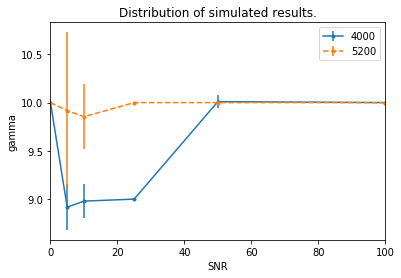

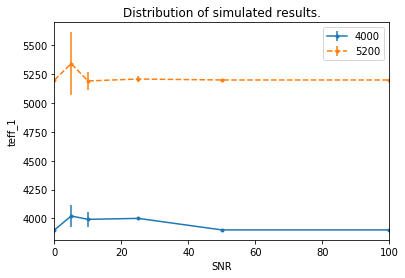

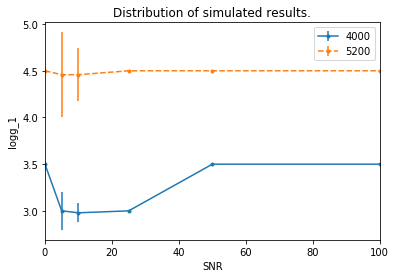

In [9]:
# Limiting the plotting axis 
analysis_param(df_bhm_store, "gamma", bhm_teffs, individual=False, limits=[0,100])
analysis_param(df_bhm_store, "teff_1", bhm_teffs, individual=False, limits=[0,100])
analysis_param(df_bhm_store, "logg_1", bhm_teffs, individual=False, limits=[0,100])


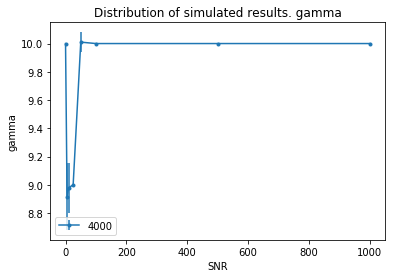

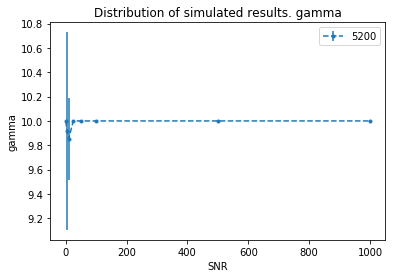

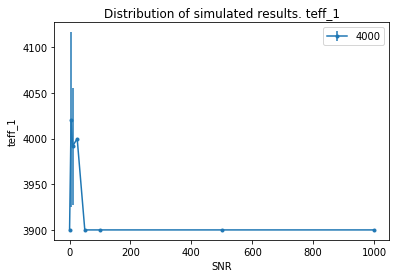

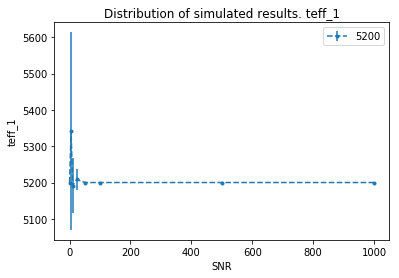

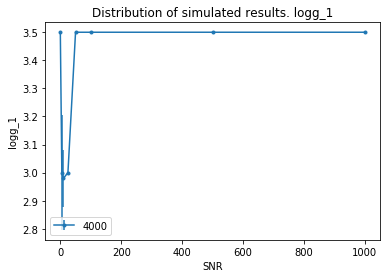

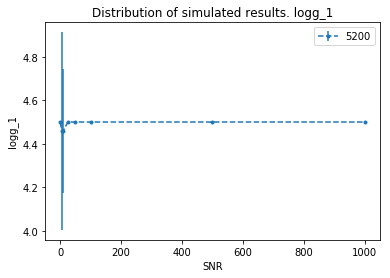

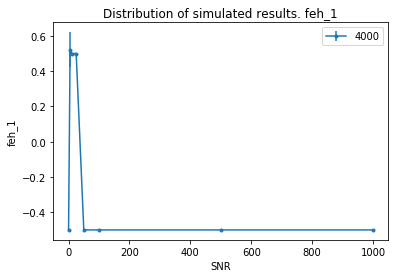

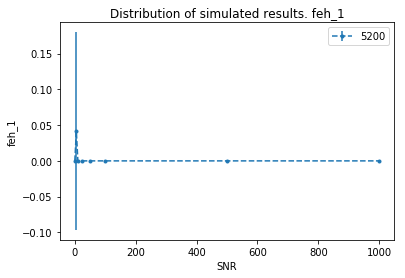

In [10]:
# Each parameter plotted individually
analysis_param(df_bhm_store, "gamma", bhm_teffs, individual=True)
analysis_param(df_bhm_store, "teff_1", bhm_teffs, individual=True)
analysis_param(df_bhm_store, "logg_1", bhm_teffs, individual=True)
analysis_param(df_bhm_store, "feh_1", bhm_teffs, individual=True)


# Exploring the impact of none, scalar renormalizing, linear renormalizing models to "observations" in chi2 recovery.

In [11]:
BHMSimReader = SimReader(base="/home/jneal/Desktop/Inbox/a/bhm_noise_sim/analysis",
                         namebase="BSBHMNOISE",
                         prefix="",
                         mode="bhm")

df_scale_store = [[0]*len(noises) for n in range(len(scale))]
print(df_scale_store)
teff = 6000
for i, pref in enumerate(scale):
    print("scale = {}".format(pref))
    for j, noise in enumerate(noises):
        BHMSimReader.prefix = pref
        df = BHMSimReader.load_results(teff, noise)   
        df_scale_store[i][j] = df

        

[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]]
scale = 
scale = SCALAR
scale = LINEAR


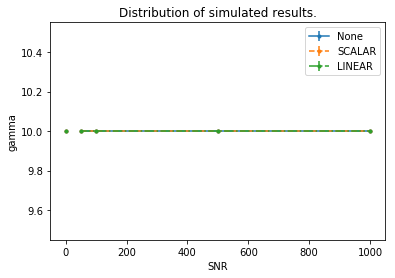

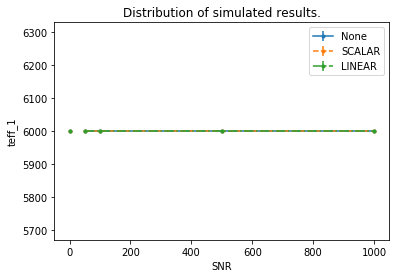

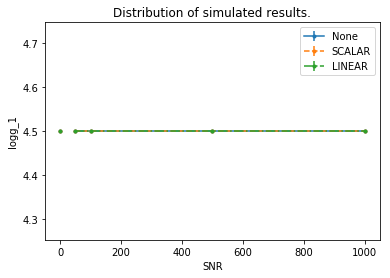

In [12]:
analysis_param(df_scale_store, "gamma", scale)  
analysis_param(df_scale_store, "teff_1", scale) 
analysis_param(df_scale_store, "logg_1", scale)

[[<__main__.SnrDistribution object at 0x7fdb218b67f0>, <__main__.SnrDistribution object at 0x7fdb21727ac8>, <__main__.SnrDistribution object at 0x7fdb2169abe0>, <__main__.SnrDistribution object at 0x7fdb216ade48>, <__main__.SnrDistribution object at 0x7fdb216485c0>, <__main__.SnrDistribution object at 0x7fdb21798c88>, <__main__.SnrDistribution object at 0x7fdb21895668>, <__main__.SnrDistribution object at 0x7fdb215a7c18>], [<__main__.SnrDistribution object at 0x7fdb37188d68>, <__main__.SnrDistribution object at 0x7fdb2162edd8>, <__main__.SnrDistribution object at 0x7fdb217073c8>, <__main__.SnrDistribution object at 0x7fdb21848c18>, <__main__.SnrDistribution object at 0x7fdb215f9860>, <__main__.SnrDistribution object at 0x7fdb216ddb70>, <__main__.SnrDistribution object at 0x7fdb21669c18>, <__main__.SnrDistribution object at 0x7fdb216238d0>]]
scale = linear
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Co

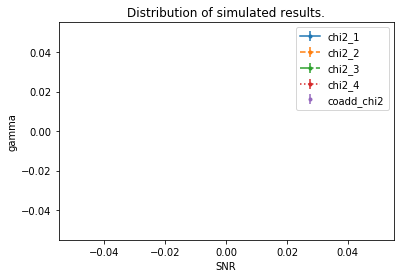

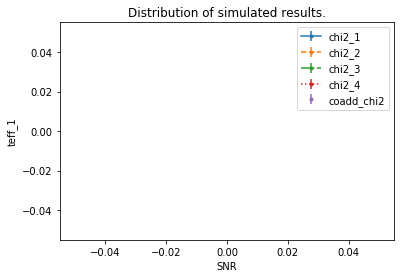

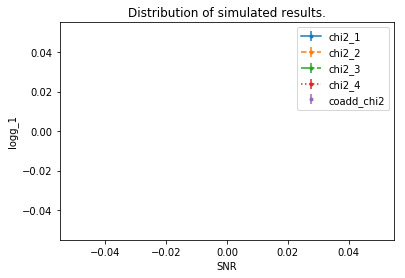

In [13]:
# Comparing the different chi2 values
chi2vals = ["chi2_1", "chi2_2", "chi2_3", "chi2_4", "coadd_chi2"]
BHMSimReader = SimReader(base="/home/jneal/Desktop/Inbox/a/bhm_noise_sim/analysis",
                         namebase="BSBHMNOISE",
                         prefix="",
                         mode="bhm")

df_chi2_store = [[0]*len(noises) for _ in chi2vals]
print(df_bhm_store)
teff = 6000
pref = "linear"
for i, chi2 in enumerate(chi2vals):
    print("scale = {}".format(pref))
    for j, noise in enumerate(noises):
        BHMSimReader.prefix = pref
        BHMSimReader.prefix = chi2
        df = BHMSimReader.load_results(teff, noise)
        print(df.df.head())
        df_chi2_store[i][j] = df

        
analysis_param(df_chi2_store, "gamma", chi2vals)  
analysis_param(df_chi2_store, "teff_1", chi2vals) 
analysis_param(df_chi2_store, "logg_1", chi2vals)
